# Validating a Linear Regression: 2013 NYC Crime Statistics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import warnings
warnings.filterwarnings(action="ignore", module="seaborn", message="^internal gelsd")


In [2]:

raw = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv',
                skiprows=4)
raw = raw.truncate(after=347)

In [3]:
raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
df = pd.DataFrame(raw[['City', 'Population']])

df['Population'] = df['Population'].apply(lambda x: int(x.replace(',','')))
df['ViolentCrime'] = raw['Violent\ncrime']
df['Murder'] = raw['Murder and\nnonnegligent\nmanslaughter']
df['Rape'] = raw['Rape\n(legacy\ndefinition)2']
df['Robbery'] = raw['Robbery']
df['AggravatedAssault'] = raw['Aggravated\nassault']
df['PropertyCrime'] = raw['Property\ncrime']
df['Burglary'] = raw['Burglary']
df['Larceny'] = raw['Larceny-\ntheft']
df['CarTheft'] = raw['Motor\nvehicle\ntheft']
df['Arson'] = raw['Arson3'].fillna(0)

In [5]:

df['ViolentCrime'] = df['ViolentCrime'].apply(lambda x: float(str(x).replace(',','')))
df['Murder'] = df['Murder'].apply(lambda x: float(str(x).replace(',','')))
df['Rape'] = df['Rape'].apply(lambda x: float(str(x).replace(',','')))
df['Robbery'] = df['Robbery'].apply(lambda x: float(str(x).replace(',','')))
df['AggravatedAssault'] = df['AggravatedAssault'].apply(lambda x: float(str(x).replace(',','')))
df['PropertyCrime'] = df['PropertyCrime'].apply(lambda x: float(str(x).replace(',','')))
df['Burglary'] = df['Burglary'].apply(lambda x: float(str(x).replace(',','')))
df['Larceny'] = df['Larceny'].apply(lambda x: float(str(x).replace(',','')))
df['CarTheft'] = df['CarTheft'].apply(lambda x: float(str(x).replace(',','')))
df['Arson'] = df['Arson'].apply(lambda x: float(str(x).replace(',','')))

## General comment (from UCR Program Data Declaration:)

"This table provides the volume of violent crime (murder and nonnegligent manslaughter, rape, robbery, and aggravated assault) and property crime (burglary, larceny-theft, and motor vehicle theft) as reported by city and town law enforcement agencies (listed alphabetically by state) that contributed data to the UCR Program. (Note:  Arson is not included in the property crime total in this table; however, if complete arson data were provided, they will appear in the arson column.)"


Burglary, Larceny, and CarTheft are all examples of property crimes, so we won't be using those as features for our linear regression.

In [6]:
df.isnull().values.any()

False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
City                 348 non-null object
Population           348 non-null int64
ViolentCrime         348 non-null float64
Murder               348 non-null float64
Rape                 348 non-null float64
Robbery              348 non-null float64
AggravatedAssault    348 non-null float64
PropertyCrime        348 non-null float64
Burglary             348 non-null float64
Larceny              348 non-null float64
CarTheft             348 non-null float64
Arson                348 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 32.7+ KB


In [8]:
df.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.003763e+04,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.005747
std,4.500374e+05,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,7.884612
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,0.000000
max,8.396126e+06,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [9]:
df.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,Adams Village,1861,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,0.0
4,Albion Village,6388,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0,0.0


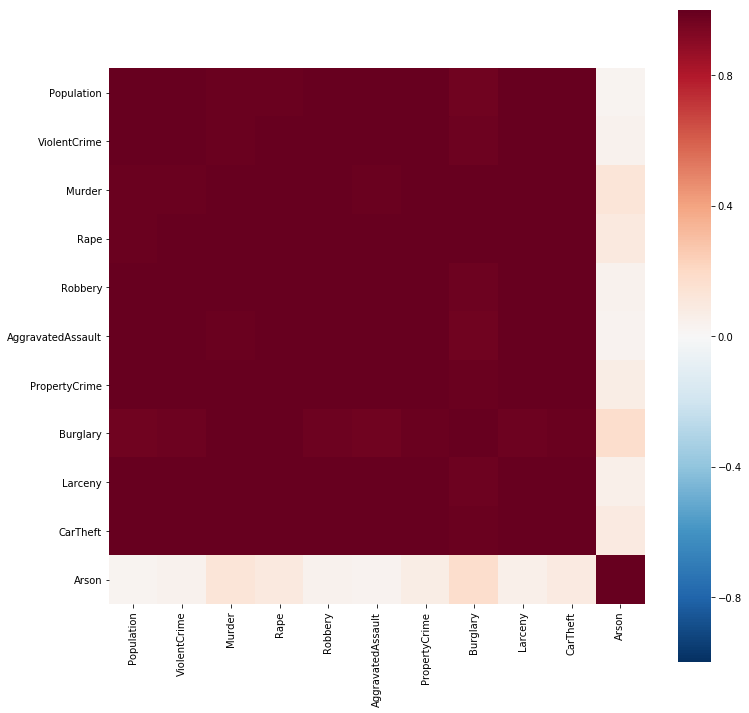

In [10]:
# Heatmap for features, pre-transformations:

plt.rcParams['figure.figsize'] = 12, 12

f = sns.heatmap(df.corr(), vmin= -1, vmax=1, square=True, cmap="RdBu_r")

plt.show()

## Functions for Encoding Features:

### Histograms of Transformed Variables:

In [11]:
plothisto = False

def plotcolumn(plotterm, df=df):
    if plothisto == True:
    
        plt.rcParams['figure.figsize'] = 12, 8
        fig = plt.figure()

        fig.add_subplot(231)
        plt.hist(df[plotterm])
        plt.title('{} Raw'.format(plotterm))

        fig.add_subplot(232)
        plt.hist(np.log(df[plotterm]+1))
        plt.title('{} Log'.format(plotterm))

        fig.add_subplot(233)
        plt.hist((df[plotterm])**2)
        plt.title('{} Square'.format(plotterm))

        fig.add_subplot(235)
        plt.hist(np.sqrt(df[plotterm]+1))
        plt.title('{} Square Root'.format(plotterm))

        ax3=fig.add_subplot(236)
        plt.hist(1/(df[plotterm]+1))
        plt.title('{} Inverse'.format(plotterm))
        plt.xticks(rotation=90)
        plt.show()

In [12]:
plotcolumn('Population')

In [13]:
plotcolumn('ViolentCrime')

In [14]:
plotcolumn('Murder')

In [15]:
plotcolumn('Rape')

In [16]:
plotcolumn('Robbery')

In [17]:
plotcolumn('AggravatedAssault')

In [18]:
plotcolumn('PropertyCrime')

In [19]:
plotcolumn('Burglary')

In [20]:
plotcolumn('Larceny')

In [21]:
plotcolumn('CarTheft')

In [22]:
plotcolumn('Arson')

### Converting Continuous Features to Booleans:

In [23]:
# Percent of nonzero entries in each column.
# Try converting some variables to booleans.

(348 - df[df == 0].count())/348

City                 1.000000
Population           1.000000
ViolentCrime         0.853448
Murder               0.140805
Rape                 0.413793
Robbery              0.600575
AggravatedAssault    0.810345
PropertyCrime        0.982759
Burglary             0.939655
Larceny              0.979885
CarTheft             0.732759
Arson                0.155172
dtype: float64

In [24]:
def toboolean(x):
    if x > 0:
        return 1
    else:
        return 0

# Linear Regression Model Tests:

## Suggested Model:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [25]:
features1 = pd.DataFrame(df[['PropertyCrime', 'Murder', 'Robbery', 'Population']])

In [26]:
features1['PopulationSquared'] = features1['Population'].apply(lambda x: x**2)
features1['Murder'] = features1['Murder'].apply(lambda x: toboolean(x))
features1['Robbery'] = features1['Robbery'].apply(lambda x: toboolean(x))

In [27]:
features1.corr()

,PropertyCrime,Murder,Robbery,Population,PopulationSquared
PropertyCrime,1.000000,0.190670,0.079318,0.996265,0.991027
Murder,0.190670,1.000000,0.313271,0.162309,0.133067
Robbery,0.079318,0.313271,1.000000,0.064371,0.043983
Population,0.996265,0.162309,0.064371,1.000000,0.998264
PopulationSquared,0.991027,0.133067,0.043983,0.998264,1.000000


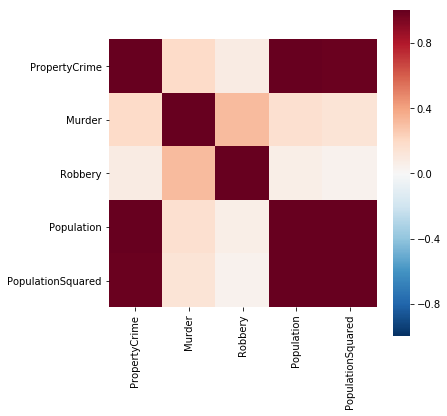

In [28]:
plt.rcParams['figure.figsize'] = 6, 6
sns.heatmap(features1.corr(), vmax=1, vmin=-1, square=True, cmap='RdBu_r')
plt.show()

In [29]:
features1.head()

,PropertyCrime,Murder,Robbery,Population,PopulationSquared
0,12.0,0,0,1861,3463321
1,24.0,0,0,2577,6640929
2,16.0,0,0,2846,8099716
3,4090.0,1,1,97956,9595377936
4,223.0,0,1,6388,40806544


In [30]:
linear_formula = 'PropertyCrime ~ Population+PopulationSquared+Murder+Robbery'
data = features1

lm = smf.ols(formula=linear_formula, data=data).fit()

In [31]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -1.095753e+02
Population           3.465703e-02
PopulationSquared   -2.111080e-09
Murder               1.518665e+01
Robbery             -9.627744e+01
dtype: float64

Intercept            7.870415e-03
Population           9.300525e-98
PopulationSquared    5.233643e-41
Murder               8.625065e-01
Robbery              9.118127e-02
dtype: float64

0.99612471049887086

,0,1
Intercept,-1.901969e+02,-2.895379e+01
Population,3.238134e-02,3.693271e-02
PopulationSquared,-2.380877e-09,-1.841284e-09
Murder,-1.571631e+02,1.875364e+02
Robbery,-2.080681e+02,1.551319e+01


#### R-Squared is too high:

In [32]:
reg = LinearRegression()

def lr_model_results(X, y):

    #Instantiate Linear Regression model:
    reg = LinearRegression()

    # Fit our model to our data.
    reg.fit(X, y)

    # Inspect the result:
    print('\nCoefficients: \n', reg.coef_)
    print('\nIntercept: \n', reg.intercept_)
    print('\nR-squared:')
    print(reg.score(X, y), '\n')

    cvscore = cross_val_score(reg, X, y, cv=10)
    print('Cross-Validation Score:\n', cvscore)
    print('Cross-Validation Mean:\n', cvscore.mean())
    print('Cross-Validation Spread:\n', (cvscore.max()-cvscore.min()))

### Model Coefficients and Cross-Validation:

In [33]:
X = features1.iloc[:,1:]
y = features1.PropertyCrime.values.reshape(-1, 1)

In [34]:
X.corr()

,Murder,Robbery,Population,PopulationSquared
Murder,1.000000,0.313271,0.162309,0.133067
Robbery,0.313271,1.000000,0.064371,0.043983
Population,0.162309,0.064371,1.000000,0.998264
PopulationSquared,0.133067,0.043983,0.998264,1.000000


In [35]:
lr_model_results(X, y)


Coefficients: 
 [[  1.51397004e+01  -9.62788861e+01   3.46571388e-02  -2.11107931e-09]]

Intercept: 
 [-109.57251855]

R-squared:
0.99612471045 

Cross-Validation Score:
 [  7.60521283e-01   8.23392356e-01  -9.16323445e-03   5.04917097e-01
   4.74255264e-01   4.19970155e-01  -3.37873806e+03   8.21730941e-01
   8.86331576e-01  -9.81034431e-01]
Cross-Validation Mean:
 -337.503713878
Cross-Validation Spread:
 3379.62439136


### Visualization of Residuals:

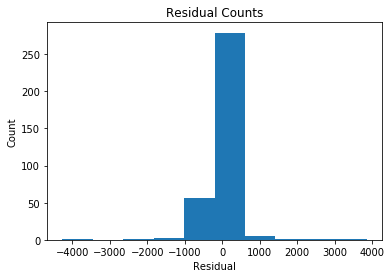

In [36]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features1['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

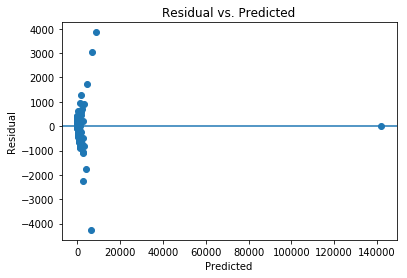

In [37]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Summary:

This looks overfit. The R-Squared values in the cross validation are anomalous. Back to the drawing board.

## Log Transformations and Feature Selection

In [38]:
features2 = pd.DataFrame(df.drop(['City'], axis=1))

In [39]:
features2.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,1861,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,2577,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,2846,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,97956,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,0.0
4,6388,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0,0.0


In [40]:
features2['Population'] = np.log(features2['Population']+1)
features2['PropertyCrime'] = np.log(features2['PropertyCrime']+1)

In [41]:
for feature in features2.columns:
    if feature == 'Population' or feature ==  'PropertyCrime':
        pass
    else:
        features2[feature] = features2[feature].apply(lambda x: toboolean(x))

In [42]:
features2.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,7.529406,0,0,0,0,0,2.564949,1,1,0,0
1,7.854769,1,0,0,0,1,3.218876,1,1,1,0
2,7.954021,1,0,0,0,1,2.833213,1,1,0,0
3,11.492284,1,1,1,1,1,8.316545,1,1,1,0
4,8.762333,1,0,1,1,1,5.411646,1,1,1,0


In [43]:
features2.corr()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
Population,1.000000,0.427992,0.502563,0.553586,0.582247,0.425383,0.869090,0.358751,0.212422,0.483086,0.285326
ViolentCrime,0.427992,1.000000,0.167753,0.348155,0.508127,0.856563,0.557033,0.372693,0.345752,0.429117,0.177595
Murder,0.502563,0.167753,1.000000,0.381186,0.313271,0.195844,0.481778,0.102588,0.058001,0.225805,0.214409
Rape,0.553586,0.348155,0.381186,1.000000,0.470749,0.302276,0.622595,0.212913,0.120375,0.283244,0.268387
Robbery,0.582247,0.508127,0.313271,0.470749,1.000000,0.428592,0.677184,0.286105,0.175686,0.448838,0.203670
AggravatedAssault,0.425383,0.856563,0.195844,0.302276,0.428592,1.000000,0.535125,0.339135,0.296159,0.403539,0.207334
PropertyCrime,0.869090,0.557033,0.481778,0.622595,0.677184,0.535125,1.000000,0.490612,0.393148,0.557840,0.320150
Burglary,0.358751,0.372693,0.102588,0.212913,0.286105,0.339135,0.490612,1.000000,0.479420,0.337818,0.075278
Larceny,0.212422,0.345752,0.058001,0.120375,0.175686,0.296159,0.393148,0.479420,1.000000,0.237247,0.061404
CarTheft,0.483086,0.429117,0.225805,0.283244,0.448838,0.403539,0.557840,0.337818,0.237247,1.000000,0.169144


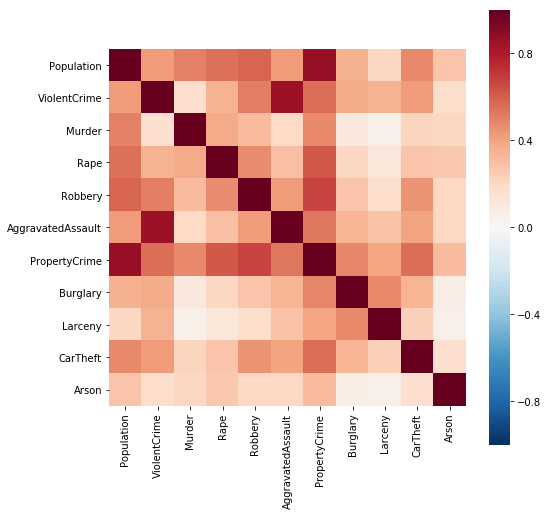

In [44]:
plt.rcParams['figure.figsize'] = 8, 8
sns.heatmap(features2.corr(), vmax=1, vmin=-1, square=True, cmap='RdBu_r')
plt.show()

## Feature Set 2: Population and ViolentCrime

In [45]:
linear_formula = 'PropertyCrime ~ Population+ViolentCrime'
data = features2

lm = smf.ols(formula=linear_formula, data=data).fit()

In [46]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept      -5.581744
Population      1.048532
ViolentCrime    1.081800
dtype: float64

Intercept       3.384037e-54
Population      9.734301e-94
ViolentCrime    8.451282e-16
dtype: float64

0.79724951189567517

,0,1
Intercept,-6.170264,-4.993225
Population,0.976888,1.120176
ViolentCrime,0.829904,1.333696


### Model Coefficients and Cross-Validation:

In [47]:
X = features2[['Population', 'ViolentCrime']]
y = features2.PropertyCrime.values.reshape(-1, 1)

In [48]:
X.corr()

,Population,ViolentCrime
Population,1.000000,0.427992
ViolentCrime,0.427992,1.000000


In [49]:
lr_model_results(X, y)


Coefficients: 
 [[ 1.04853234  1.08179988]]

Intercept: 
 [-5.58174437]

R-squared:
0.797249511896 

Cross-Validation Score:
 [ 0.79304956  0.86613971  0.38298515  0.84396672  0.73322698  0.71471619
  0.86515027  0.80429518  0.76609521  0.85447782]
Cross-Validation Mean:
 0.76241027856
Cross-Validation Spread:
 0.483154565202


### Visualization of Residuals:

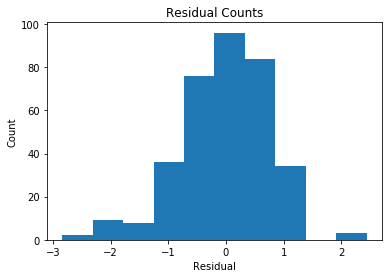

In [50]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features2['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

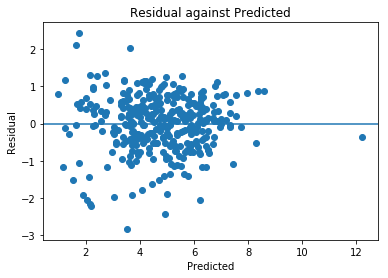

In [51]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:

The R-squared value for this model looks much more realistic, although there's still a great deal of variance in the cross-validation score. The residual graph looks reasonably homoscedastic.

## Feature Set 3: Population, Murder, Robbery, Rape, AggravatedAssault, Arson

In [52]:
linear_formula = 'PropertyCrime ~ Population+Murder+Robbery+Rape+AggravatedAssault+Arson'
data = features2

lm = smf.ols(formula=linear_formula, data=data).fit()

In [53]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -3.629637
Population           0.806041
Murder               0.174236
Robbery              0.635333
Rape                 0.476820
AggravatedAssault    0.632092
Arson                0.176358
dtype: float64

Intercept            1.597852e-22
Population           2.830406e-53
Murder               1.647485e-01
Robbery              3.501318e-10
Rape                 7.236812e-07
AggravatedAssault    1.328413e-08
Arson                1.056989e-01
dtype: float64

0.83515606498262818

,0,1
Intercept,-4.309749,-2.949524
Population,0.720193,0.891889
Murder,-0.071918,0.420389
Robbery,0.442045,0.828621
Rape,0.291074,0.662566
AggravatedAssault,0.418615,0.845568
Arson,-0.037488,0.390204


P-values for Murder and Arson look higher than the rest. The next model will not include Murder.

### Model Coefficients and Cross-Validation:

In [54]:
X = features2[['Population', 'Murder', 'Robbery', 'Rape', 'AggravatedAssault', 'Arson']]
y = features2.PropertyCrime.values.reshape(-1, 1)

In [55]:
X.corr()

,Population,Murder,Robbery,Rape,AggravatedAssault,Arson
Population,1.000000,0.502563,0.582247,0.553586,0.425383,0.285326
Murder,0.502563,1.000000,0.313271,0.381186,0.195844,0.214409
Robbery,0.582247,0.313271,1.000000,0.470749,0.428592,0.203670
Rape,0.553586,0.381186,0.470749,1.000000,0.302276,0.268387
AggravatedAssault,0.425383,0.195844,0.428592,0.302276,1.000000,0.207334
Arson,0.285326,0.214409,0.203670,0.268387,0.207334,1.000000


In [56]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.80604121  0.17423565  0.63533308  0.47681964  0.63209164  0.17635812]]

Intercept: 
 [-3.62963653]

R-squared:
0.835156064983 

Cross-Validation Score:
 [ 0.87497779  0.88580415  0.52621895  0.87594876  0.7738298   0.74881057
  0.89194796  0.828977    0.79611835  0.84399204]
Cross-Validation Mean:
 0.804662535814
Cross-Validation Spread:
 0.365729003396


### Visualization of Residuals:

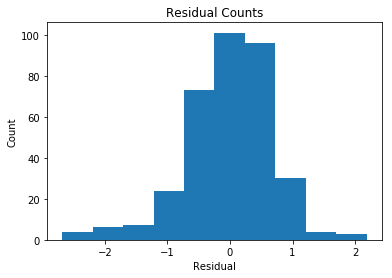

In [57]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features2['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

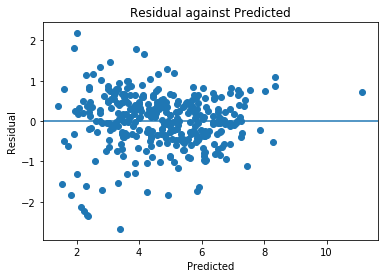

In [58]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:

It looks like 'Murder' here is a weaker predictor than the other features, so on the next iteration, we'll try removing it. The residuals still look pretty good except for a few outliers.

## Feature Set 4: Population, Robbery, Rape, Aggravated Assault, Arson

In [59]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault+Arson'
data = features2

lm = smf.ols(formula=linear_formula, data=data).fit()

In [60]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -3.792515
Population           0.826503
Robbery              0.636254
Rape                 0.494134
AggravatedAssault    0.625640
Arson                0.187069
dtype: float64

Intercept            1.323151e-26
Population           8.155434e-60
Robbery              3.476214e-10
Rape                 2.404573e-07
AggravatedAssault    1.855944e-08
Arson                8.586184e-02
dtype: float64

0.83421901146081701

,0,1
Intercept,-4.433388,-3.151642
Population,0.745558,0.907448
Robbery,0.442707,0.829800
Rape,0.309755,0.678513
AggravatedAssault,0.412068,0.839212
Arson,-0.026531,0.400669


### Model Coefficients and Cross-Validation:

In [61]:
X = features2[['Population', 'Robbery', 'Rape', 'AggravatedAssault', 'Arson']]
y = features2.PropertyCrime.values.reshape(-1, 1)

In [62]:
X.corr()

,Population,Robbery,Rape,AggravatedAssault,Arson
Population,1.000000,0.582247,0.553586,0.425383,0.285326
Robbery,0.582247,1.000000,0.470749,0.428592,0.203670
Rape,0.553586,0.470749,1.000000,0.302276,0.268387
AggravatedAssault,0.425383,0.428592,0.302276,1.000000,0.207334
Arson,0.285326,0.203670,0.268387,0.207334,1.000000


In [63]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.82650273  0.63625367  0.49413397  0.62563993  0.18706926]]

Intercept: 
 [-3.79251471]

R-squared:
0.834219011461 

Cross-Validation Score:
 [ 0.87273103  0.88474976  0.52220773  0.87595854  0.7750516   0.74533128
  0.89026961  0.82817653  0.79757193  0.84590233]
Cross-Validation Mean:
 0.803795033925
Cross-Validation Spread:
 0.368061887529


### Visualization of Residuals:

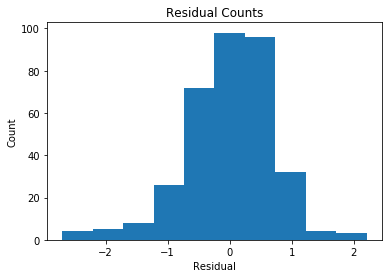

In [64]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features2['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

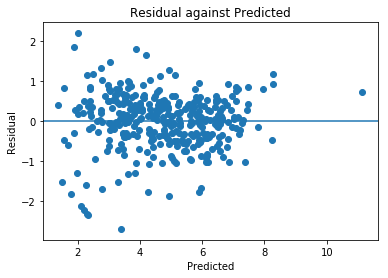

In [65]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:

Removing 'Murder' had minimal effect on the R-Squared value, and the residual continues to be fairly consistent. Next, we will remove 'Arson.'

## Feature Set 5: Population, Robbery, Rape, Aggravated Assault

In [66]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features2

lm = smf.ols(formula=linear_formula, data=data).fit()

In [67]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -3.864764
Population           0.835419
Robbery              0.635896
Rape                 0.514874
AggravatedAssault    0.641747
dtype: float64

Intercept            1.141311e-27
Population           3.729724e-61
Robbery              3.945408e-10
Rape                 6.606911e-08
AggravatedAssault    8.015392e-09
dtype: float64

0.8327805905313922

,0,1
Intercept,-4.502119,-3.227410
Population,0.754888,0.915950
Robbery,0.441798,0.829994
Rape,0.331500,0.698247
AggravatedAssault,0.428361,0.855133


### Model Coefficients and Cross-Validation:

In [68]:
X = features2[['Population', 'Robbery', 'Rape', 'AggravatedAssault', 'Arson']]
y = features2.PropertyCrime.values.reshape(-1, 1)

In [69]:
X.corr()

,Population,Robbery,Rape,AggravatedAssault,Arson
Population,1.000000,0.582247,0.553586,0.425383,0.285326
Robbery,0.582247,1.000000,0.470749,0.428592,0.203670
Rape,0.553586,0.470749,1.000000,0.302276,0.268387
AggravatedAssault,0.425383,0.428592,0.302276,1.000000,0.207334
Arson,0.285326,0.203670,0.268387,0.207334,1.000000


In [70]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.82650273  0.63625367  0.49413397  0.62563993  0.18706926]]

Intercept: 
 [-3.79251471]

R-squared:
0.834219011461 

Cross-Validation Score:
 [ 0.87273103  0.88474976  0.52220773  0.87595854  0.7750516   0.74533128
  0.89026961  0.82817653  0.79757193  0.84590233]
Cross-Validation Mean:
 0.803795033925
Cross-Validation Spread:
 0.368061887529


### Visualization of Residuals:

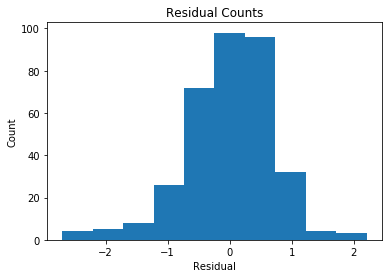

In [71]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features2['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

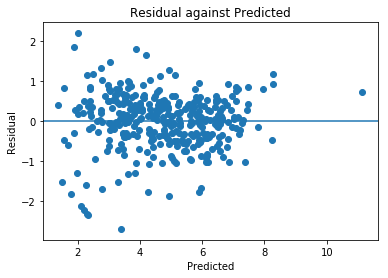

In [72]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:

Removing 'Arson' also had minimal effect on the R-Squared value. Let's try removing the outliers of cities with larger populations.

## Removed Largest Cities (>20000 Population)

In [73]:
features3 = pd.DataFrame(features2[features2['Population'] < np.log(20000)])

In [74]:
features3.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,7.529406,0,0,0,0,0,2.564949,1,1,0,0
1,7.854769,1,0,0,0,1,3.218876,1,1,1,0
2,7.954021,1,0,0,0,1,2.833213,1,1,0,0
4,8.762333,1,0,1,1,1,5.411646,1,1,1,0
5,8.316300,1,0,0,1,1,3.850148,1,1,0,0


## FINAL Feature Set 6: Population, Robbery, Rape, AggravatedAssault

In [75]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features3

lm = smf.ols(formula=linear_formula, data=data).fit()

In [76]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -3.151342
Population           0.743705
Robbery              0.688817
Rape                 0.504506
AggravatedAssault    0.690503
dtype: float64

Intercept            4.356087e-09
Population           3.176174e-24
Robbery              8.842188e-10
Rape                 7.712920e-06
AggravatedAssault    6.516486e-09
dtype: float64

0.71803497848506381

,0,1
Intercept,-4.173073,-2.129611
Population,0.613467,0.873944
Robbery,0.475567,0.902066
Rape,0.286832,0.722180
AggravatedAssault,0.463865,0.917140


From this model, it looks like Rape has the lowest P-value, so we will try removing it in the next model.

### Model Coefficients and Cross-Validation:

In [77]:
X = features3[['Population', 'Robbery', 'Rape', 'AggravatedAssault']]
y = features3.PropertyCrime.values.reshape(-1, 1)

In [78]:
X.corr()

,Population,Robbery,Rape,AggravatedAssault
Population,1.000000,0.510560,0.433997,0.403521
Robbery,0.510560,1.000000,0.409348,0.369596
Rape,0.433997,0.409348,1.000000,0.242444
AggravatedAssault,0.403521,0.369596,0.242444,1.000000


In [79]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.74370542  0.68881686  0.50450621  0.69050261]]

Intercept: 
 [-3.15134235]

R-squared:
0.718034978485 

Cross-Validation Score:
 [ 0.72346708  0.73553465  0.5866953   0.78269915  0.6360088   0.6163781
  0.77812796  0.6128135   0.67327431  0.65072874]
Cross-Validation Mean:
 0.679572759236
Cross-Validation Spread:
 0.196003852039


### Visualization of Residuals:

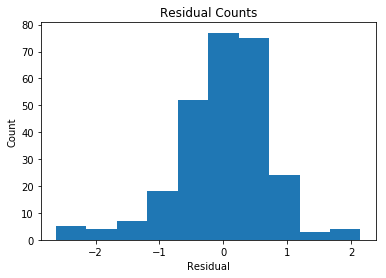

In [80]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features3['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

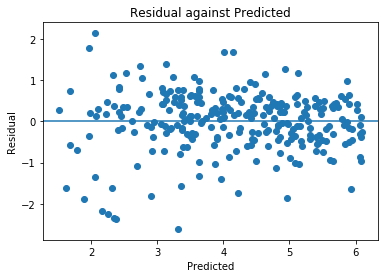

In [81]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:



The R-squared value is lower, but the cross-validation scores are much closer together. Additionally, this model shows the spread of residuals better. Let's try reducing the features once again:

## Feature Set 7: Population, Robbery, AggravatedAssault

In [82]:
linear_formula = 'PropertyCrime ~ Population+Robbery+AggravatedAssault'
data = features3

lm = smf.ols(formula=linear_formula, data=data).fit()

In [83]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -3.756107
Population           0.825001
Robbery              0.803098
AggravatedAssault    0.707810
dtype: float64

Intercept            5.453603e-12
Population           1.809098e-28
Robbery              2.438024e-12
AggravatedAssault    9.183281e-09
dtype: float64

0.69579169144084596

,0,1
Intercept,-4.780227,-2.731987
Population,0.694970,0.955032
Robbery,0.588010,1.018186
AggravatedAssault,0.472979,0.942641


### Model Coefficients and Cross-Validation:

In [84]:
X = features3[['Population', 'Robbery', 'AggravatedAssault']]
y = features3.PropertyCrime.values.reshape(-1, 1)

In [85]:
X.corr()

,Population,Robbery,AggravatedAssault
Population,1.000000,0.510560,0.403521
Robbery,0.510560,1.000000,0.369596
AggravatedAssault,0.403521,0.369596,1.000000


In [86]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.8250011   0.80309774  0.7078098 ]]

Intercept: 
 [-3.75610667]

R-squared:
0.695791691441 

Cross-Validation Score:
 [ 0.6765541   0.71579923  0.54202425  0.81103221  0.62275654  0.5726423
  0.75111132  0.61409908  0.64380934  0.5925183 ]
Cross-Validation Mean:
 0.65423466544
Cross-Validation Spread:
 0.269007955368


### Visualization of Residuals:

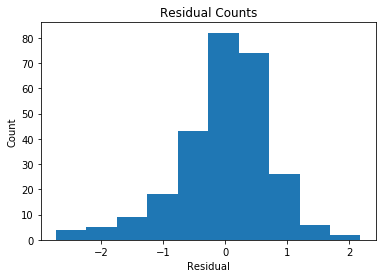

In [87]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features3['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

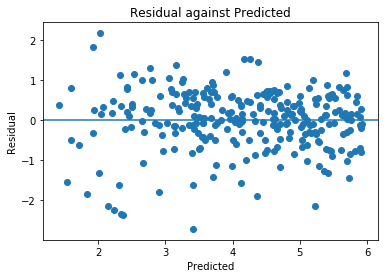

In [88]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

### Summary:

The R-squared value dropped, and the cross-validation test was worse. The Population+Robbery+Rape+AggravatedAssault combination seems to have done the best so far.

In [90]:
X = features3[['Population', 'Robbery', 'Rape', 'AggravatedAssault']]
y = features3.PropertyCrime.values.reshape(-1, 1)

X.corr()

,Population,Robbery,Rape,AggravatedAssault
Population,1.000000,0.510560,0.433997,0.403521
Robbery,0.510560,1.000000,0.409348,0.369596
Rape,0.433997,0.409348,1.000000,0.242444
AggravatedAssault,0.403521,0.369596,0.242444,1.000000


# Import Second Dataset:

In [141]:
raw2 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', header=4, skipfooter=7)

In [142]:
raw2.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1851,0,0,NaN,0.0,0,0,11.0,1,10.0,0,0.0
1,Addison Town and Village,2568,2,0,NaN,0.0,1,1,49.0,1,47.0,1,0.0
2,Afton Village4,820,0,0,0.0,NaN,0,0,1.0,0,1.0,0,0.0
3,Akron Village,2842,1,0,NaN,0.0,0,1,17.0,0,17.0,0,0.0
4,Albany4,98595,802,8,54.0,NaN,237,503,3888.0,683,3083.0,122,12.0


In [93]:
df2 = pd.DataFrame(raw2[['City', 'Population']])


df2['ViolentCrime'] = raw2['Violent\ncrime'].fillna(0.0)
df2['Murder'] = raw2['Murder and\nnonnegligent\nmanslaughter'].fillna(0.0)
df2['Rape'] = raw2['Rape\n(revised\ndefinition)1'].fillna(0.0)
df2['Rape2'] = raw2['Rape\n(legacy\ndefinition)2'].fillna(0.0)
df2['Robbery'] = raw2['Robbery'].fillna(0.0)
df2['AggravatedAssault'] = raw2['Aggravated\nassault'].fillna(0.0)
df2['PropertyCrime'] = raw2['Property\ncrime'].fillna(0.0)
df2['Burglary'] = raw2['Burglary'].fillna(0.0)
df2['Larceny'] = raw2['Larceny-\ntheft'].fillna(0.0)
df2['CarTheft'] = raw2['Motor\nvehicle\ntheft'].fillna(0.0)
df2['Arson'] = raw2['Arson3'].fillna(0)

In [94]:
df2['ViolentCrime'] = df2['ViolentCrime'].apply(lambda x: float(str(x).replace(',','')))
df2['Murder'] = df2['Murder'].apply(lambda x: float(str(x).replace(',','')))
df2['Rape'] = df2['Rape'].apply(lambda x: float(str(x).replace(',','')))
df2['Rape2'] = df2['Rape2'].apply(lambda x: float(str(x).replace(',','')))
df2['Robbery'] = df2['Robbery'].apply(lambda x: float(str(x).replace(',','')))
df2['AggravatedAssault'] = df2['AggravatedAssault'].apply(lambda x: float(str(x).replace(',','')))
df2['PropertyCrime'] = df2['PropertyCrime'].apply(lambda x: float(str(x).replace(',','')))
df2['Burglary'] = df2['Burglary'].apply(lambda x: float(str(x).replace(',','')))
df2['Larceny'] = df2['Larceny'].apply(lambda x: float(str(x).replace(',','')))
df2['CarTheft'] = df2['CarTheft'].apply(lambda x: float(str(x).replace(',','')))
df2['Arson'] = df2['Arson'].apply(lambda x: float(str(x).replace(',','')))

In [95]:
df2['Rape'] = df2['Rape'] + df2['Rape2']
df2.drop('Rape2', axis=1, inplace=True)


In [96]:
df2.isnull().values.any()

False

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 12 columns):
City                 369 non-null object
Population           369 non-null int64
ViolentCrime         369 non-null float64
Murder               369 non-null float64
Rape                 369 non-null float64
Robbery              369 non-null float64
AggravatedAssault    369 non-null float64
PropertyCrime        369 non-null float64
Burglary             369 non-null float64
Larceny              369 non-null float64
CarTheft             369 non-null float64
Arson                369 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 34.7+ KB


In [98]:
df2.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
count,3.690000e+02,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,3.781482e+04,183.691057,1.452575,9.571816,60.661247,112.005420,696.468835,100.899729,561.265583,34.317073,1.409214
std,4.411591e+05,2638.842310,17.693912,114.869424,866.480865,1640.514852,7114.021364,855.103473,5861.942843,406.956766,7.952852
min,7.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.631000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.000000,20.000000,0.000000,0.000000
50%,6.581000e+03,5.000000,0.000000,0.000000,1.000000,3.000000,75.000000,12.000000,60.000000,2.000000,0.000000
75%,1.540800e+04,18.000000,0.000000,2.000000,4.000000,12.000000,270.000000,39.000000,228.000000,6.000000,1.000000
max,8.473938e+06,50564.000000,333.000000,2190.000000,16581.000000,31460.000000,135747.000000,15916.000000,112107.000000,7724.000000,135.000000


In [99]:
df2.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,Adams Village,1851,0.0,0.0,0.0,0.0,0.0,11.0,1.0,10.0,0.0,0.0
1,Addison Town and Village,2568,2.0,0.0,0.0,1.0,1.0,49.0,1.0,47.0,1.0,0.0
2,Afton Village4,820,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Akron Village,2842,1.0,0.0,0.0,0.0,1.0,17.0,0.0,17.0,0.0,0.0
4,Albany4,98595,802.0,8.0,54.0,237.0,503.0,3888.0,683.0,3083.0,122.0,12.0


In [100]:
features_ny_2014 = pd.DataFrame(df2.drop(['City'], axis=1))

In [101]:
features_ny_2014.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,1851,0.0,0.0,0.0,0.0,0.0,11.0,1.0,10.0,0.0,0.0
1,2568,2.0,0.0,0.0,1.0,1.0,49.0,1.0,47.0,1.0,0.0
2,820,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2842,1.0,0.0,0.0,0.0,1.0,17.0,0.0,17.0,0.0,0.0
4,98595,802.0,8.0,54.0,237.0,503.0,3888.0,683.0,3083.0,122.0,12.0


## Log Transformation on Population, PropertyCrime:

In [102]:
features_ny_2014['Population'] = np.log(features_ny_2014['Population']+1)
features_ny_2014['PropertyCrime'] = np.log(features_ny_2014['PropertyCrime']+1)

## Continuous Features to Booleans:

In [103]:
for feature in features_ny_2014.columns:
    if feature == 'Population' or feature ==  'PropertyCrime':
        pass
    else:
        features_ny_2014[feature] = features_ny_2014[feature].apply(lambda x: toboolean(x))

In [104]:
features_ny_2014.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,7.524021,0,0,0,0,0,2.484907,1,1,0,0
1,7.851272,1,0,0,1,1,3.912023,1,1,1,0
2,6.710523,0,0,0,0,0,0.693147,0,1,0,0
3,7.952615,1,0,0,0,1,2.890372,0,1,0,0
4,11.498786,1,1,1,1,1,8.265907,1,1,1,1


In [105]:
features_ny_2014.corr()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
Population,1.000000,0.522583,0.531927,0.466695,0.633224,0.496020,0.843063,0.342695,0.193112,0.514107,0.458929
ViolentCrime,0.522583,1.000000,0.197178,0.389421,0.524074,0.830298,0.545464,0.437325,0.275592,0.411667,0.291139
Murder,0.531927,0.197178,1.000000,0.264256,0.313300,0.201683,0.509245,0.131674,0.070198,0.192321,0.310967
Rape,0.466695,0.389421,0.264256,1.000000,0.408222,0.342058,0.548738,0.241281,0.138639,0.369321,0.377013
Robbery,0.633224,0.524074,0.313300,0.408222,1.000000,0.408381,0.669699,0.313368,0.154645,0.515586,0.378810
AggravatedAssault,0.496020,0.830298,0.201683,0.342058,0.408381,1.000000,0.526385,0.346287,0.222953,0.410281,0.300152
PropertyCrime,0.843063,0.545464,0.509245,0.548738,0.669699,0.526385,1.000000,0.494246,0.396086,0.631713,0.494760
Burglary,0.342695,0.437325,0.131674,0.241281,0.313368,0.346287,0.494246,1.000000,0.264596,0.324824,0.184240
Larceny,0.193112,0.275592,0.070198,0.138639,0.154645,0.222953,0.396086,0.264596,1.000000,0.268973,0.109077
CarTheft,0.514107,0.411667,0.192321,0.369321,0.515586,0.410281,0.631713,0.324824,0.268973,1.000000,0.299871


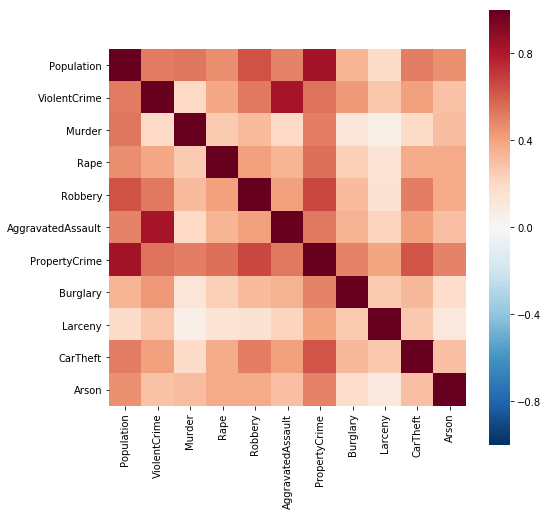

In [106]:
plt.rcParams['figure.figsize'] = 8, 8
sns.heatmap(features_ny_2014.corr(), vmax=1, vmin=-1, square=True, cmap='RdBu_r')
plt.show()

# Use Model on Second Dataset:

In [107]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features_ny_2014

lm = smf.ols(formula=linear_formula, data=data).fit()

In [108]:
print('Intercept/Coefficients: \n', lm.params)

Intercept/Coefficients: 
 Intercept           -4.025817
Population           0.851515
Robbery              0.657174
Rape                 0.588553
AggravatedAssault    0.401570
dtype: float64


In [109]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -4.025817
Population           0.851515
Robbery              0.657174
Rape                 0.588553
AggravatedAssault    0.401570
dtype: float64

Intercept            1.371570e-22
Population           2.281655e-48
Robbery              7.840708e-08
Rape                 8.476953e-08
AggravatedAssault    1.007543e-03
dtype: float64

0.77060592982831455

,0,1
Intercept,-4.782165,-3.269469
Population,0.753357,0.949674
Robbery,0.421468,0.892880
Rape,0.376882,0.800224
AggravatedAssault,0.163374,0.639765


In [110]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features_ny_2014

lm = smf.ols(formula=linear_formula, data=data).fit()

### Model Coefficients and Cross-Validation:

In [111]:
X = features_ny_2014[['Population', 'Robbery', 'Rape', 'AggravatedAssault']]
y = features_ny_2014.PropertyCrime.values.reshape(-1, 1)

In [112]:
X.corr()

,Population,Robbery,Rape,AggravatedAssault
Population,1.000000,0.633224,0.466695,0.496020
Robbery,0.633224,1.000000,0.408222,0.408381
Rape,0.466695,0.408222,1.000000,0.342058
AggravatedAssault,0.496020,0.408381,0.342058,1.000000


In [113]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.85151519  0.65717417  0.5885527   0.40156977]]

Intercept: 
 [-4.02581689]

R-squared:
0.770605929828 

Cross-Validation Score:
 [ 0.85721434  0.83317477  0.45678095  0.85664799  0.73296935  0.73871716
  0.7775534   0.7693375   0.74321944  0.63592345]
Cross-Validation Mean:
 0.740153835559
Cross-Validation Spread:
 0.400433384167


### Visualization of Residuals:

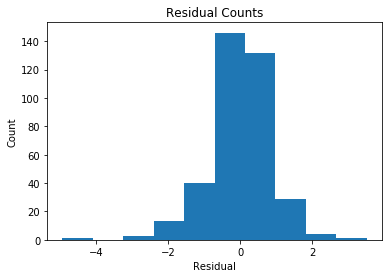

In [114]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features_ny_2014['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

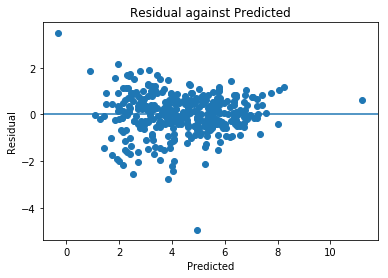

In [115]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

The results for 2014 New York crime data are fairly homoscedastic, with a higher R-squared value. However, there is less consistency in cross-validation.

# Import Third Dataset:

In [116]:
raw3 = pd.read_excel('table-8-pennsylvania.xls', header=4, skipfooter=4)

In [117]:
raw3.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,"Abington Township, Lackawanna County",1750,1,0,0,NaN,0,1,14,4,10,0,0.0
1,"Abington Township, Montgomery County",55559,63,0,5,NaN,28,30,1146,169,952,25,4.0
2,Adamstown,1845,0,0,0,NaN,0,0,20,4,12,4,0.0
3,"Adams Township, Butler County",12582,8,0,0,NaN,0,8,63,11,51,1,0.0
4,"Adams Township, Cambria County",5868,0,0,0,NaN,0,0,25,9,16,0,0.0


In [118]:
df3 = pd.DataFrame(raw3[['City', 'Population']])


df3['ViolentCrime'] = raw3['Violent\ncrime'].fillna(0.0)
df3['Murder'] = raw3['Murder and\nnonnegligent\nmanslaughter'].fillna(0.0)
df3['Rape'] = raw3['Rape\n(revised\ndefinition)1'].fillna(0.0)
df3['Rape2'] = raw3['Rape\n(legacy\ndefinition)2'].fillna(0.0)
df3['Robbery'] = raw3['Robbery'].fillna(0.0)
df3['AggravatedAssault'] = raw3['Aggravated\nassault'].fillna(0.0)
df3['PropertyCrime'] = raw3['Property\ncrime'].fillna(0.0)
df3['Burglary'] = raw3['Burglary'].fillna(0.0)
df3['Larceny'] = raw3['Larceny-\ntheft'].fillna(0.0)
df3['CarTheft'] = raw3['Motor\nvehicle\ntheft'].fillna(0.0)
df3['Arson'] = raw3['Arson3'].fillna(0)

In [119]:
df3['ViolentCrime'] = df3['ViolentCrime'].apply(lambda x: float(str(x).replace(',','')))
df3['Murder'] = df3['Murder'].apply(lambda x: float(str(x).replace(',','')))
df3['Rape'] = df3['Rape'].apply(lambda x: float(str(x).replace(',','')))
df3['Rape2'] = df3['Rape2'].apply(lambda x: float(str(x).replace(',','')))
df3['Robbery'] = df3['Robbery'].apply(lambda x: float(str(x).replace(',','')))
df3['AggravatedAssault'] = df3['AggravatedAssault'].apply(lambda x: float(str(x).replace(',','')))
df3['PropertyCrime'] = df3['PropertyCrime'].apply(lambda x: float(str(x).replace(',','')))
df3['Burglary'] = df3['Burglary'].apply(lambda x: float(str(x).replace(',','')))
df3['Larceny'] = df3['Larceny'].apply(lambda x: float(str(x).replace(',','')))
df3['CarTheft'] = df3['CarTheft'].apply(lambda x: float(str(x).replace(',','')))
df3['Arson'] = df3['Arson'].apply(lambda x: float(str(x).replace(',','')))

In [120]:
df3['Rape'] = df3['Rape'] + df3['Rape2']
df3.drop('Rape2', axis=1, inplace=True)


In [121]:
df3.isnull().values.any()

False

In [122]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 12 columns):
City                 853 non-null object
Population           853 non-null int64
ViolentCrime         853 non-null float64
Murder               853 non-null float64
Rape                 853 non-null float64
Robbery              853 non-null float64
AggravatedAssault    853 non-null float64
PropertyCrime        853 non-null float64
Burglary             853 non-null float64
Larceny              853 non-null float64
CarTheft             853 non-null float64
Arson                853 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 80.0+ KB


In [123]:
df3.describe()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
count,8.530000e+02,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,1.076485e+04,42.044549,0.583822,3.228605,15.815944,22.416178,242.760844,44.302462,184.899179,13.559203,1.087925
std,5.512654e+04,591.939678,8.674964,44.209176,261.944888,277.743315,1884.982159,372.300831,1316.937843,200.144057,7.538820
min,1.980000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.403000e+03,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,4.000000,16.000000,0.000000,0.000000
50%,4.626000e+03,5.000000,0.000000,0.000000,0.000000,4.000000,68.000000,11.000000,55.000000,2.000000,0.000000
75%,1.014000e+04,16.000000,0.000000,1.000000,3.000000,11.000000,171.000000,25.000000,143.000000,5.000000,1.000000
max,1.553153e+06,17074.000000,247.000000,1279.000000,7562.000000,7986.000000,53452.000000,10408.000000,37253.000000,5791.000000,208.000000


In [124]:
df3.head()

,City,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,"Abington Township, Lackawanna County",1750,1.0,0.0,0.0,0.0,1.0,14.0,4.0,10.0,0.0,0.0
1,"Abington Township, Montgomery County",55559,63.0,0.0,5.0,28.0,30.0,1146.0,169.0,952.0,25.0,4.0
2,Adamstown,1845,0.0,0.0,0.0,0.0,0.0,20.0,4.0,12.0,4.0,0.0
3,"Adams Township, Butler County",12582,8.0,0.0,0.0,0.0,8.0,63.0,11.0,51.0,1.0,0.0
4,"Adams Township, Cambria County",5868,0.0,0.0,0.0,0.0,0.0,25.0,9.0,16.0,0.0,0.0


In [125]:
features_pa_2013 = pd.DataFrame(df3.drop(['City'], axis=1))

In [126]:
features_pa_2013.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,1750,1.0,0.0,0.0,0.0,1.0,14.0,4.0,10.0,0.0,0.0
1,55559,63.0,0.0,5.0,28.0,30.0,1146.0,169.0,952.0,25.0,4.0
2,1845,0.0,0.0,0.0,0.0,0.0,20.0,4.0,12.0,4.0,0.0
3,12582,8.0,0.0,0.0,0.0,8.0,63.0,11.0,51.0,1.0,0.0
4,5868,0.0,0.0,0.0,0.0,0.0,25.0,9.0,16.0,0.0,0.0


## Log Transformation on Population, PropertyCrime:

In [127]:
features_pa_2013['Population'] = np.log(features_pa_2013['Population']+1)
features_pa_2013['PropertyCrime'] = np.log(features_pa_2013['PropertyCrime']+1)

## Continuous Features to Booleans:

In [128]:
for feature in features_pa_2013.columns:
    if feature == 'Population' or feature ==  'PropertyCrime':
        pass
    else:
        features_pa_2013[feature] = features_pa_2013[feature].apply(lambda x: toboolean(x))

In [129]:
features_pa_2013.head()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
0,7.467942,1,0,0,0,1,2.708050,1,1,0,0
1,10.925219,1,0,1,1,1,7.044905,1,1,1,1
2,7.520776,0,0,0,0,0,3.044522,1,1,1,0
3,9.440102,1,0,0,0,1,4.158883,1,1,1,0
4,8.677440,0,0,0,0,0,3.258097,1,1,0,0


In [130]:
features_pa_2013.corr()

,Population,ViolentCrime,Murder,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,Larceny,CarTheft,Arson
Population,1.000000,0.468459,0.372930,0.517332,0.536349,0.458213,0.849660,0.458486,0.373496,0.518589,0.428246
ViolentCrime,0.468459,1.000000,0.153508,0.358211,0.425058,0.872347,0.580606,0.499144,0.437700,0.400891,0.247683
Murder,0.372930,0.153508,1.000000,0.261574,0.234420,0.166622,0.384051,0.117776,0.086447,0.209558,0.268190
Rape,0.517332,0.358211,0.261574,1.000000,0.451093,0.302807,0.555932,0.258887,0.201724,0.384227,0.343714
Robbery,0.536349,0.425058,0.234420,0.451093,1.000000,0.351934,0.604613,0.286969,0.219015,0.412023,0.364707
AggravatedAssault,0.458213,0.872347,0.166622,0.302807,0.351934,1.000000,0.561613,0.453261,0.389150,0.387303,0.258005
PropertyCrime,0.849660,0.580606,0.384051,0.555932,0.604613,0.561613,1.000000,0.603270,0.568386,0.624188,0.454768
Burglary,0.458486,0.499144,0.117776,0.258887,0.286969,0.453261,0.603270,1.000000,0.598124,0.395064,0.211788
Larceny,0.373496,0.437700,0.086447,0.201724,0.219015,0.389150,0.568386,0.598124,1.000000,0.325069,0.155452
CarTheft,0.518589,0.400891,0.209558,0.384227,0.412023,0.387303,0.624188,0.395064,0.325069,1.000000,0.278775


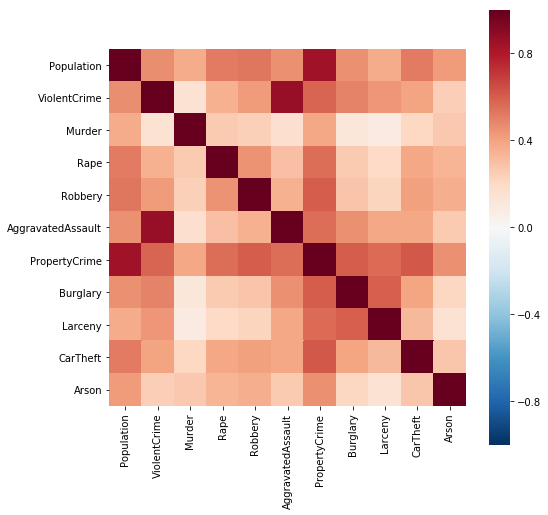

In [131]:
plt.rcParams['figure.figsize'] = 8, 8
sns.heatmap(features_pa_2013.corr(), vmax=1, vmin=-1, square=True, cmap='RdBu_r')
plt.show()

# Use Model on Second Dataset:

In [132]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features_pa_2013

lm = smf.ols(formula=linear_formula, data=data).fit()

In [133]:
print('Intercept/Coefficients: \n', lm.params)

Intercept/Coefficients: 
 Intercept           -4.922126
Population           0.938438
Robbery              0.517249
Rape                 0.356585
AggravatedAssault    0.787151
dtype: float64


In [134]:
display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept           -4.922126
Population           0.938438
Robbery              0.517249
Rape                 0.356585
AggravatedAssault    0.787151
dtype: float64

Intercept             2.413768e-77
Population           1.039728e-133
Robbery               3.571919e-15
Rape                  4.041275e-08
AggravatedAssault     2.162021e-24
dtype: float64

0.78975341416848976

,0,1
Intercept,-5.388917,-4.455334
Population,0.876507,1.000368
Robbery,0.390619,0.643878
Rape,0.230246,0.482923
AggravatedAssault,0.640220,0.934083


In [135]:
linear_formula = 'PropertyCrime ~ Population+Robbery+Rape+AggravatedAssault'
data = features_pa_2013

lm = smf.ols(formula=linear_formula, data=data).fit()

### Model Coefficients and Cross-Validation:

In [136]:
X = features_pa_2013[['Population', 'Robbery', 'Rape', 'AggravatedAssault']]
y = features_pa_2013.PropertyCrime.values.reshape(-1, 1)

In [137]:
X.corr()

,Population,Robbery,Rape,AggravatedAssault
Population,1.000000,0.536349,0.517332,0.458213
Robbery,0.536349,1.000000,0.451093,0.351934
Rape,0.517332,0.451093,1.000000,0.302807
AggravatedAssault,0.458213,0.351934,0.302807,1.000000


In [138]:
lr_model_results(X, y)


Coefficients: 
 [[ 0.93843775  0.51724876  0.35658479  0.78715131]]

Intercept: 
 [-4.92212598]

R-squared:
0.789753414168 

Cross-Validation Score:
 [ 0.82497547  0.831412    0.73532316  0.7145815   0.78456469  0.76665453
  0.85589735  0.78234991  0.78471408  0.69622317]
Cross-Validation Mean:
 0.77766958558
Cross-Validation Spread:
 0.15967417626


### Visualization of Residuals:

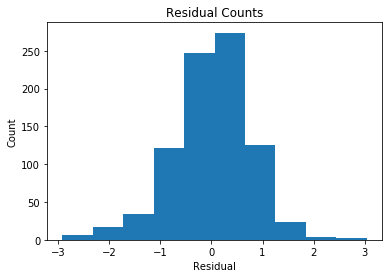

In [139]:
reg.fit(X, y)
predicted = reg.predict(X).ravel()
actual = features_pa_2013['PropertyCrime']

residual = actual - predicted
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

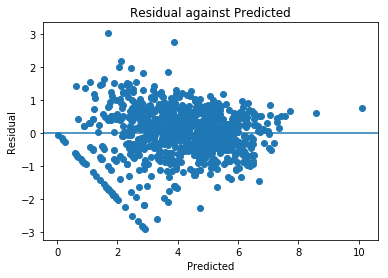

In [140]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual against Predicted')
plt.show()

The results here are mostly homoscedastic, except for some outliers in the lower left portion of the graph. The R-squared value is high, with much less variation among the cross-validation scores. 